In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# ---- Small-ε closed-form for static forces (used at Λ* = Λ ± σ) ----
def FrFt_bar(Lambda_star, L_over_D=1.0):
    """
    Dimensionless force components for the small-ε static solution at Λ*.
    F̄r + i F̄t = (i Λ*)/(1 + i Λ*) * [1 - tanh(η L/D)/(η L/D)] * (π/2),
    where η = sqrt(1 + i Λ*).
    Returns (F̄r, F̄t).
    """
    i = 1j
    eta = np.sqrt(1.0 + i * Lambda_star)
    H = 1.0 - np.tanh(eta * L_over_D) / (eta * L_over_D)
    G = (i * Lambda_star) / (1.0 + i * Lambda_star) * H * (np.pi / 2.0)
    return np.real(G), np.imag(G)  # F̄r, F̄t

# ---- Dynamic stiffness coefficients from section 9.3.2 (dimensionless) ----
def stiffness_Kxx_Kxy(Lambda, sigma_vals, L_over_D=1.0):
    """
    Compute dynamic stiffness coefficients Kxx and Kxy.
    """
    Kxx = np.zeros_like(sigma_vals, dtype=float)
    Kxy = np.zeros_like(sigma_vals, dtype=float)
    for k, s in enumerate(sigma_vals):
        Fr_m, Ft_m = FrFt_bar(Lambda - s, L_over_D)
        Fr_p, Ft_p = FrFt_bar(Lambda + s, L_over_D)
        Kxx[k] = 0.5 * (Fr_m + Fr_p)
        Kxy[k] = -0.5 * (Ft_m + Ft_p)
    return Kxx, Kxy

In [4]:

# ---- Small-ε closed-form building blocks ----
def FrFt_bar(Lambda_star, L_over_D=1.0):
    """
    Dimensionless force components (small-ε static solution) at Λ*.
    F̄r + i F̄t = (i Λ*)/(1 + i Λ*) * [1 - tanh(η L/D)/(η L/D)] * (π/2),
    with η = sqrt(1 + i Λ*).
    """
    i = 1j
    eta = np.sqrt(1.0 + i * Lambda_star)
    H = 1.0 - np.tanh(eta * L_over_D) / (eta * L_over_D)
    G = (i * Lambda_star) / (1.0 + i * Lambda_star) * H * (np.pi / 2.0)
    return np.real(G), np.imag(G)  # F̄r, F̄t

def damping_Cxx_Cxy(Lambda, sigma_vals, L_over_D=1.0):
    """
    Dynamic damping coefficients (dimensionless) for given Λ over σ:
    CXX = -[F̄t(Λ-σ) - F̄t(Λ+σ)]/(2σ)
    CXY = +[F̄r(Λ-σ) - F̄r(Λ+σ)]/(2σ)
    """
    Cxx = np.zeros_like(sigma_vals, dtype=float)
    Cxy = np.zeros_like(sigma_vals, dtype=float)
    for k, s in enumerate(sigma_vals):
        s_eff = s if s != 0 else 1e-12
        Fr_m, Ft_m = FrFt_bar(Lambda - s_eff, L_over_D)
        Fr_p, Ft_p = FrFt_bar(Lambda + s_eff, L_over_D)
        Cxx[k] = -(Ft_m - Ft_p) / (2.0 * s_eff)
        Cxy[k] = +(Fr_m - Fr_p) / (2.0 * s_eff)
    return Cxx, Cxy


In [5]:

# ---- Physical/geometry parameters ----
mu   = 1.85e-5        # Pa·s (air, ~20–25°C)
pa   = 101325.0       # Pa   (ambient/reference pressure)
R    = 10e-3          # m    shaft radius
c    = 10e-6          # m    radial clearance
L_over_D = 1.0        # L/D = 1

# ---- Dimensionless helper ----
Rc_ratio_sq = (R / c) ** 2

# ---- Define perturbation frequency ν (rad/s), then compute σ properly ----
nu = np.logspace(0, 5, 600)                 # rad/s (e.g., 1 to 1e5)
sigma = 12.0 * mu * nu / pa * Rc_ratio_sq   # σ = (12 μ ν / p_a) * (R/c)^2

# ---- Bearing numbers Λ to plot (can also be computed from ω if desired) ----
Lambda_list = [0.1, 1, 5, 10, 100, 1000]


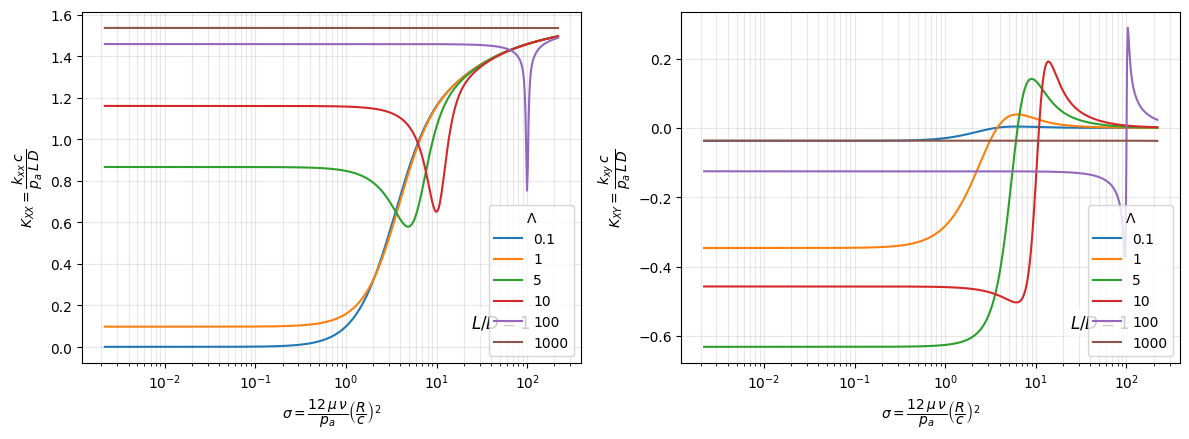

In [6]:
# ---- Plotting ----
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# KXX(σ)
for Lambda in Lambda_list:
    Kxx, Kxy = stiffness_Kxx_Kxy(Lambda, sigma, L_over_D)
    ax1.plot(sigma, Kxx, label=f"{Lambda:g}")
ax1.set_xscale('log')
ax1.set_xlabel(r"$\sigma = \dfrac{12\,\mu\,\nu}{p_a}\left(\dfrac{R}{c}\right)^2$")
ax1.set_ylabel(r"$K_{XX} = \dfrac{k_{xx}\,c}{p_a\,L\,D}$")
ax1.grid(True, which='both', alpha=0.3)
ax1.legend(title=r"$\Lambda$", loc="best")
ax1.text(0.78, 0.1, r"$L/D = 1$", transform=ax1.transAxes, fontsize=12,
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# KXY(σ)
for Lambda in Lambda_list:
    Kxx, Kxy = stiffness_Kxx_Kxy(Lambda, sigma, L_over_D)
    ax2.plot(sigma, Kxy, label=f"{Lambda:g}")
ax2.set_xscale('log')
ax2.set_xlabel(r"$\sigma = \dfrac{12\,\mu\,\nu}{p_a}\left(\dfrac{R}{c}\right)^2$")
ax2.set_ylabel(r"$K_{XY} = \dfrac{k_{xy}\,c}{p_a\,L\,D}$")
ax2.grid(True, which='both', alpha=0.3)
ax2.legend(title=r"$\Lambda$", loc="best")
ax2.text(0.78, 0.1, r"$L/D = 1$", transform=ax2.transAxes, fontsize=12,
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.tight_layout()
plt.show()

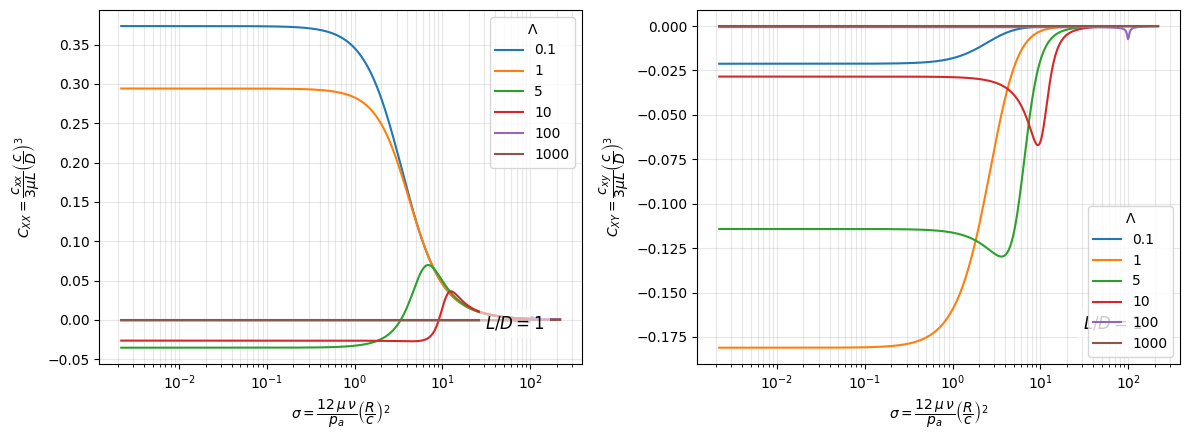

In [7]:
# ---- Dimensionless helper ----
Rc_ratio_sq = (R / c) ** 2

# ---- Define physical perturbation frequency ν (rad/s), then compute σ properly ----
nu = np.logspace(0, 5, 600)  # rad/s, e.g. 1 to 1e5
sigma = 12.0 * mu * nu / pa * Rc_ratio_sq  # σ = (12 μ ν / p_a) * (R/c)^2

# ---- Choose bearing numbers Λ to plot (could also compute from ω) ----
Lambda_list = [0.1, 1, 5, 10, 100, 1000]
# If desired, compute Λ from rotor speed ω (rad/s):
# omega = 2*np.pi*60000  # example 60 krpm
# Lambda = 6.0 * mu * omega / pa * Rc_ratio_sq

# ---- Plotting ----
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# CXX(σ)
for Lambda in Lambda_list:
    Cxx, Cxy = damping_Cxx_Cxy(Lambda, sigma, L_over_D)
    ax1.plot(sigma, Cxx, label=f"{Lambda:g}")
ax1.set_xscale('log')
ax1.set_xlabel(r"$\sigma = \dfrac{12\,\mu\,\nu}{p_a}\left(\dfrac{R}{c}\right)^2$")
ax1.set_ylabel(r"$C_{XX} = \dfrac{c_{xx}}{3\mu L}\left(\dfrac{c}{D}\right)^3$")
ax1.grid(True, which='both', alpha=0.3)
ax1.legend(title=r"$\Lambda$", loc="best")
ax1.text(0.8, 0.1, r"$L/D = 1$", transform=ax1.transAxes, fontsize=12,
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# CXY(σ)
for Lambda in Lambda_list:
    Cxx, Cxy = damping_Cxx_Cxy(Lambda, sigma, L_over_D)
    ax2.plot(sigma, Cxy, label=f"{Lambda:g}")
ax2.set_xscale('log')
ax2.set_xlabel(r"$\sigma = \dfrac{12\,\mu\,\nu}{p_a}\left(\dfrac{R}{c}\right)^2$")
ax2.set_ylabel(r"$C_{XY} = \dfrac{c_{xy}}{3\mu L}\left(\dfrac{c}{D}\right)^3$")
ax2.grid(True, which='both', alpha=0.3)
ax2.legend(title=r"$\Lambda$", loc="best")
ax2.text(0.8, 0.1, r"$L/D = 1$", transform=ax2.transAxes, fontsize=12,
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.tight_layout()
plt.show()